In [1]:
from cmath import cos
from math import radians, sin, cos, pi
import os, os.path
from re import L
from statistics import mean
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utilsV2 import loadFiles, addTorque, filterEMG, slidingWindow, featureExtraction, normalizeEMG, stackFiles, filter
from emgFeatures import rms
from scipy.signal import butter, lfilter
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from classes import ERLS

In [2]:
path = 'D:\Documentos\Datasets\Grabaciones 5'

files = loadFiles(path)

In [3]:
torqueFiles = addTorque(files)

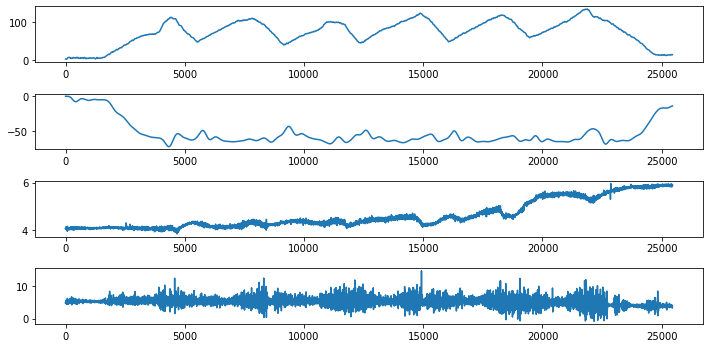

In [4]:
subject = 'subject 1'
test = '1_ext_75_21600'

fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

angle = torqueFiles[subject][test][:,4]
torque = torqueFiles[subject][test][:,5]
emg = torqueFiles[subject][test][:,0:4]

axs[0].plot(angle)
axs[1].plot(torque)
axs[2].plot(emg[:,0])
axs[3].plot(emg[:,1])

In [5]:
filteredFiles = filterEMG(torqueFiles, 500, 5, 1024)

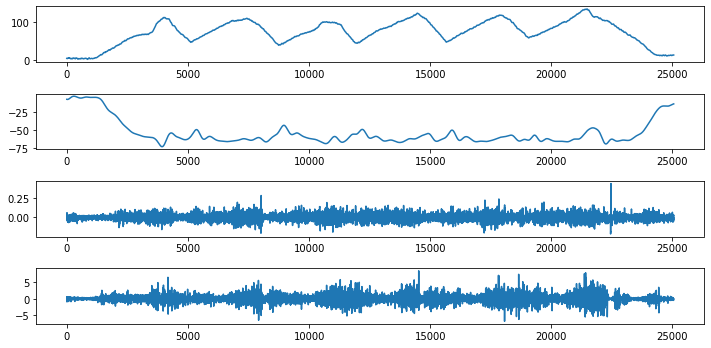

In [6]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

angle = filteredFiles[subject][test][:,4]
torque = filteredFiles[subject][test][:,5]
emg = filteredFiles[subject][test][:,0:4]

axs[0].plot(angle)
axs[1].plot(torque)
axs[2].plot(emg[:,0])
axs[3].plot(emg[:,1])

In [7]:
segmentedFiles = slidingWindow(filteredFiles, 200, 100)

In [8]:
featuresFiles = featureExtraction(segmentedFiles)

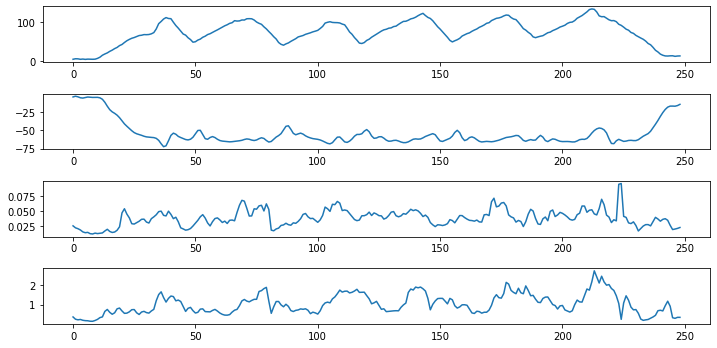

In [9]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

angle = featuresFiles[subject][test][1]
torque = featuresFiles[subject][test][2]
emg = featuresFiles[subject][test][0]

axs[0].plot(angle)
axs[1].plot(torque)
axs[2].plot(emg[:,0])
axs[3].plot(emg[:,1])

In [10]:
normalizedFiles = normalizeEMG(featuresFiles)

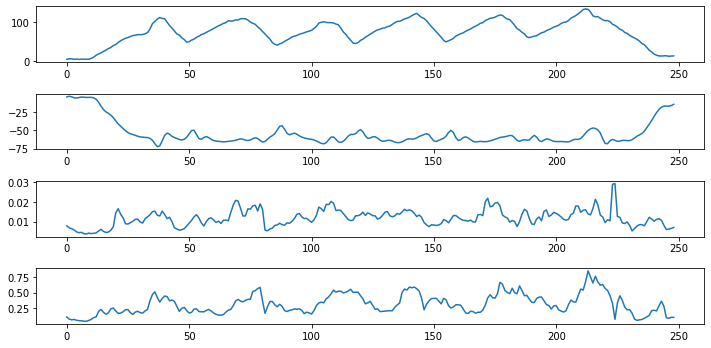

In [11]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

angle = normalizedFiles[subject][test][1]
torque = normalizedFiles[subject][test][2]
emg = normalizedFiles[subject][test][0]

axs[0].plot(angle)
axs[1].plot(torque)
axs[2].plot(emg[:,0])
axs[3].plot(emg[:,1])

In [12]:
emgData, angleData, torqueData = stackFiles(normalizedFiles)

In [13]:
print(emgData.shape)
print(angleData.shape)
print(torqueData.shape)

(8968, 4)
(8968, 1)
(8968, 1)


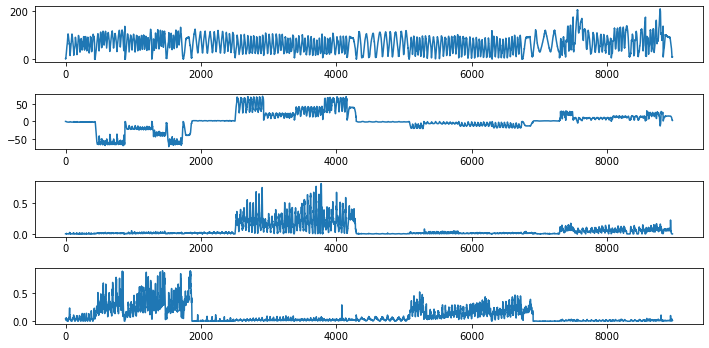

In [14]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()


axs[0].plot(angleData)
axs[1].plot(torqueData)
axs[2].plot(emgData[:,0])
axs[3].plot(emgData[:,1])

In [15]:
#emgData = filter(emgData, 1, 1/0.1)

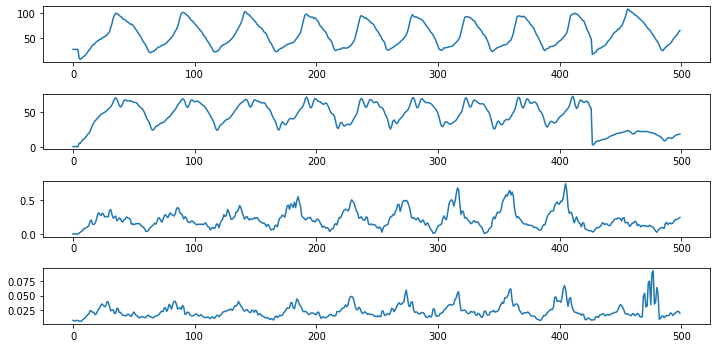

In [16]:
fig, axs = plt.subplots(4, figsize=(10,5))
fig.tight_layout()

i = 2500
n = 3000

axs[0].plot(angleData[i:n])
axs[1].plot(torqueData[i:n])
axs[2].plot(emgData[i:n,0])
axs[3].plot(emgData[i:n,1])

In [17]:
lr = RandomForestRegressor()
lr.fit(emgData[:,0:2],np.ravel(torqueData))

RandomForestRegressor()

Train R2 =  0.9543798113899352
Train MAE =  5.126104934858979


Text(0.5, 0, 'Ventana')

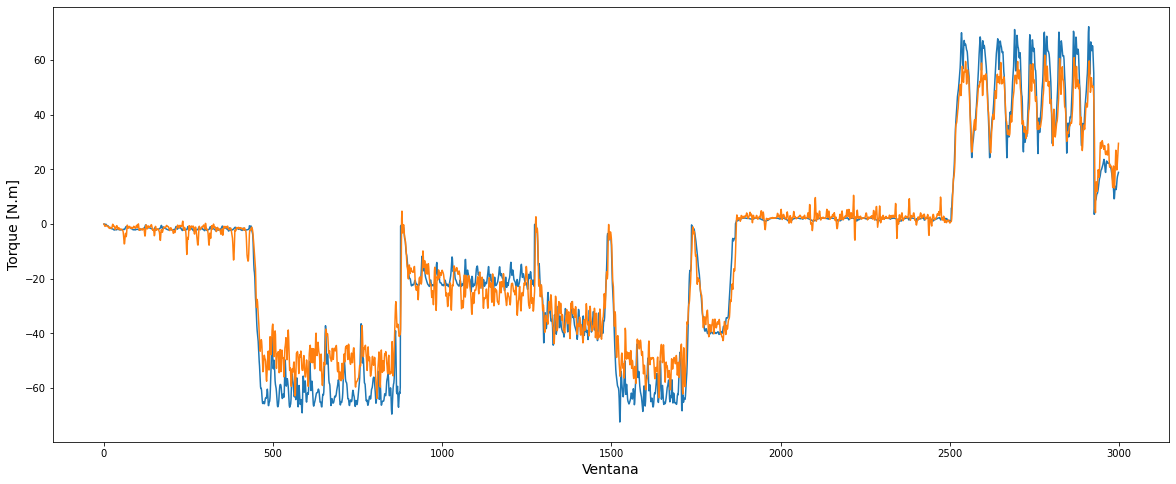

In [18]:
i = 0
n = 3000

predicted = lr.predict(emgData[i:n,0:2])
predicted = filter(predicted,2,1/0.1)
print("Train R2 = ", r2_score(np.ravel(torqueData)[i:n], predicted))
print("Train MAE = ", mean_absolute_error(np.ravel(torqueData)[i:n], predicted))

plt.figure(figsize=(20,8))
plt.plot(np.ravel(torqueData)[i:n])
plt.plot(predicted)
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)

In [28]:
erls = ERLS()
y_hat = np.zeros(emgData.shape[0])

for i in range(0,emgData.shape[0]):

    y_hat[i], theta = erls.estimate(emgData[i,0],emgData[i,1],np.ravel(torqueData)[i])

[[ 2.28426291e+00]
 [ 3.79516090e+00]
 [-2.63287668e+00]
 [-5.46108960e+00]
 [-1.48209391e+00]
 [ 5.04889767e-01]
 [-5.37584134e-03]
 [ 3.44485038e-02]]
Train R2 =  0.9994071629793326
Train MAE =  0.1807081203559868


Text(0.5, 0, 'Ventana')

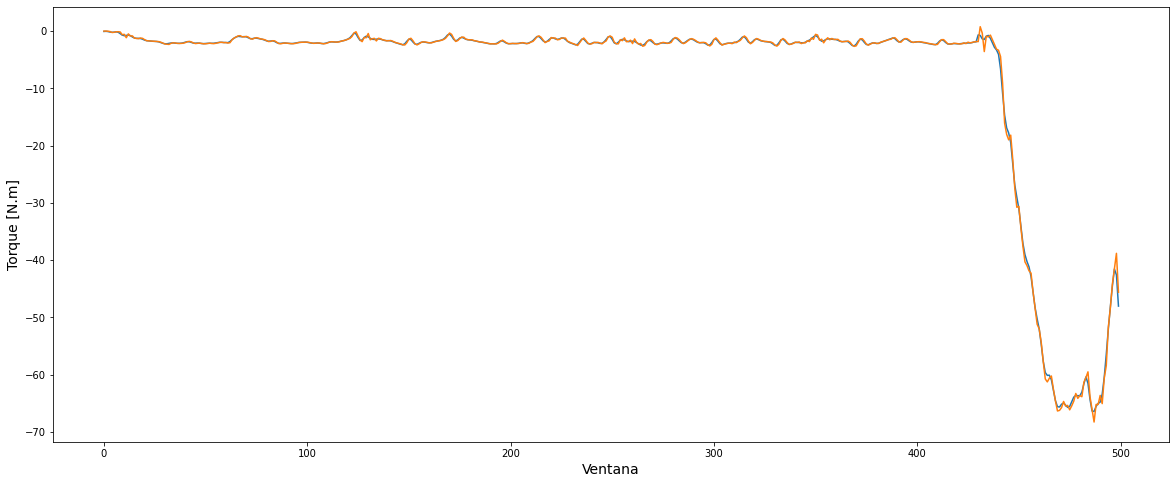

In [29]:
i = 0
n = 500

predicted = filter(predicted,2,1/0.1)
print(theta)
print("Train R2 = ", r2_score(np.ravel(torqueData)[i:n], y_hat[i:n]))
print("Train MAE = ", mean_absolute_error(np.ravel(torqueData)[i:n], y_hat[i:n]))

plt.figure(figsize=(20,8))
plt.plot(np.ravel(torqueData)[i:n])
plt.plot(y_hat[i:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)